**Mount Google Drive**

In [1]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Setup**

In [2]:
!apt-get update -qq > /dev/null
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://dlcdn.apache.org/spark/spark-3.4.2/spark-3.4.2-bin-hadoop3.tgz
!tar xf spark-3.4.2-bin-hadoop3.tgz
!pip install -q findspark

In [3]:
import os
import pandas as pd

os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.4.2-bin-hadoop3"

import findspark

findspark.init()

from pyspark.sql import SparkSession
import random

spark = SparkSession.builder.appName("YourTest") \
    .master("local[2]") \
    .config('spark.ui.port', random.randrange(4000, 5000)) \
    .config("spark.jars.packages", "graphframes:graphframes:0.8.3-spark3.4-s_2.12") \
    .getOrCreate()

from graphframes import GraphFrame
from graphframes.lib import Pregel
import pyspark.sql.functions as f

spark.sparkContext.setCheckpointDir("./checkpoint/")

In [18]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col

# Create a SparkSession
spark = SparkSession.builder.getOrCreate()

# Load the data
df = spark.read.csv("/content/drive/MyDrive/twitch_gamers/large_twitch_edges.csv", header=True)

# Get all vertices
all_vertices = df.select("numeric_id_1").union(df.select("numeric_id_2")).distinct()

# Get dead ends
missing_vertices = all_vertices.subtract(df.select("numeric_id_1").distinct())

# Add loop
missing_edges_df = missing_vertices.withColumnRenamed("numeric_id_1", "src").withColumn("dst", col("src"))

# Concatenate the dataframes
df = df.union(missing_edges_df)

df.write.option("header", "true").mode('overwrite').csv('/content/drive/MyDrive/twitch_gamers/loop.csv')


In [10]:
from pyspark.sql import functions as f
from pyspark.sql.functions import collect_set, size
from graphframes import *
from pyspark.sql.functions import sum as _sum

# Load the features DataFrame
features = spark.read.format("csv").option("header", "true").load("/content/drive/MyDrive/twitch_gamers/large_twitch_features.csv")

# Load the edges DataFrame
twitch_gamers = spark.read.format("csv").option("header", "true").load(
    "/content/drive/MyDrive/twitch_gamers/large_twitch_edges.csv").withColumnRenamed("numeric_id_1",
                                                      "src").withColumnRenamed("numeric_id_2", "dst")

vertices = twitch_gamers.select("src").union(twitch_gamers.select("dst")).distinct().withColumnRenamed("src", "id")

# Join the features DataFrame with the vertices DataFrame to add the language attribute
vertices = vertices.join(features.select("numeric_id", "language"), vertices.id == features.numeric_id, "left_outer")

# Create a new edges DataFrame where each edge represents a connection between users who speak the same language
edges = twitch_gamers.alias("e").join(vertices.alias("v1"), f.col("e.src") == f.col("v1.id")).join(vertices.alias("v2"),
          f.col("e.dst") == f.col("v2.id")).filter(f.col("v1.language") == f.col("v2.language")).select(f.col("e.src").alias("src"),
                                                                                                      f.col("e.dst").alias("dst"))

# Create the new graph
graph_language = GraphFrame(vertices, edges)

# Find connected components
connected_components = graph_language.connectedComponents()

# Group by language and component
communities_by_language = connected_components.groupBy("language", "component")

# Count the number of users in each community
communities_by_language = communities_by_language.agg(f.count("id").alias("num_users"))

# Calculate the total number of communities and users for each language
communities_by_language = communities_by_language.groupBy("language").agg(f.count("component").alias("num_communities"), _sum("num_users").alias("total_users"))

# Show the communities grouped by language
communities_by_language.show()

+--------+---------------+-----------+
|language|num_communities|total_users|
+--------+---------------+-----------+
|      FI|             44|        652|
|      NL|             82|        701|
|      PL|             50|        944|
|      RU|            146|       4821|
|      SV|            110|        854|
|      PT|             93|       2536|
|      EN|            266|     124411|
|      DE|            187|       9428|
|      ES|            169|       5699|
|      TR|             16|        772|
|      ZH|             38|       2828|
|      FR|             78|       6799|
|      DA|             50|        503|
|      IT|             28|       1230|
|      TH|              5|        632|
|   OTHER|           1296|       1429|
|      CS|              9|        576|
|      HU|             18|        427|
|      NO|             70|        330|
|      KO|             35|       1215|
+--------+---------------+-----------+
only showing top 20 rows



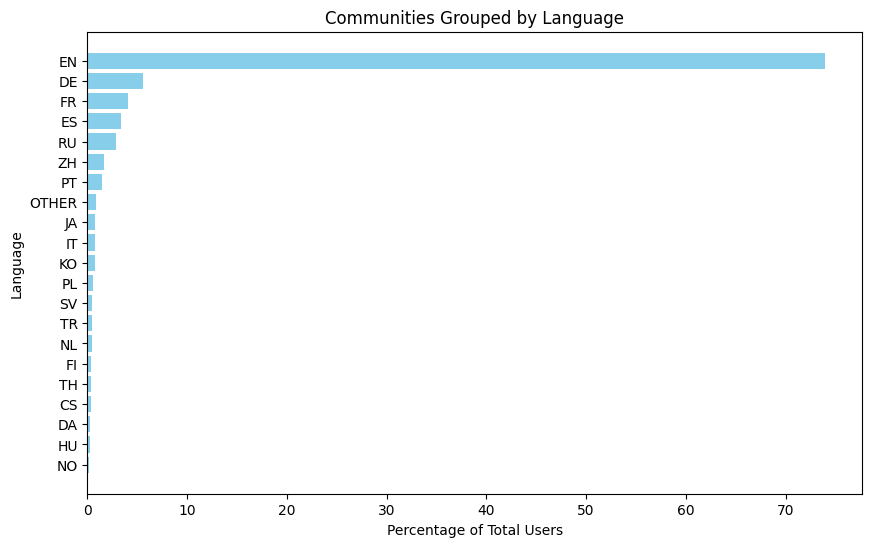

In [13]:
# Show the communities grouped by language, sorted by total_users in descending order
#communities_by_language.orderBy(f.desc("total_users")).show()
import matplotlib.pyplot as plt

# Convert the DataFrame to Pandas
communities_by_language_pd = communities_by_language.toPandas()

# Calculate the percentage of total users for each language
communities_by_language_pd['percentage'] = (communities_by_language_pd['total_users'] / communities_by_language_pd['total_users'].sum()) * 100

# Sort the data by percentage in descending order
communities_by_language_pd = communities_by_language_pd.sort_values('percentage', ascending=False)

# Plot the data
plt.figure(figsize=(10, 6))
plt.barh(communities_by_language_pd['language'], communities_by_language_pd['percentage'], color='skyblue')
plt.xlabel('Percentage of Total Users')
plt.ylabel('Language')
plt.title('Communities Grouped by Language')
plt.gca().invert_yaxis()  # invert the y-axis to show the language with the highest percentage at the top
plt.show()



In [4]:
# Read the excel file / rename columns
twitch_gamers = spark.read.format("csv").option("header", "false").load(
    "loop.csv").withColumnRenamed("_c0",
                                  "src").withColumnRenamed(
    "_c1", "dst")


vertices = twitch_gamers.select("src").union(twitch_gamers.select("dst")).distinct().withColumnRenamed("src", "id")

edges = twitch_gamers.select("src", "dst")
graph = GraphFrame(vertices, edges)

# Show graph
graph.vertices.show()
graph.edges.show()


+------+
|    id|
+------+
|113417|
|128181|
| 13772|
| 42688|
|106585|
|140876|
| 46683|
| 17427|
|102521|
|  2162|
| 29454|
| 82197|
|131033|
|154118|
|147244|
| 90391|
|149687|
| 76686|
| 57569|
| 80258|
+------+
only showing top 20 rows

+-----+------+
|  src|   dst|
+-----+------+
|98343|141493|
|98343| 58736|
|98343|140703|
|98343|151401|
|98343|157118|
|98343|125430|
|98343|  3635|
|98343|   495|
|98343|116648|
|98343|  1679|
|98343|123861|
|98343| 89631|
|98343|113417|
|98343|145281|
|98343| 10408|
|98343|  3181|
|98343| 40675|
|98343| 95914|
|98343|155127|
|98343|124827|
+-----+------+
only showing top 20 rows



**In degree function**

In [5]:
# Implement in_degree function
def in_Degrees(graph):
    in_degrees = graph.edges.groupBy("dst").count().select(f.col("dst").alias("id"),
                                                            f.col("count").alias("in_degree"))

    # for 0 outdegree
    return graph.vertices.join(in_degrees, "id", "left_outer").select("id", "in_degree").na.fill(0)

# Implement out_degree function
def out_Degrees(graph):
    out_degrees = graph.edges.groupBy("src").count().select(f.col("src").alias("id"),
                                                            f.col("count").alias("out_degree"))

    # for 0 outdegree
    return graph.vertices.join(out_degrees, "id", "left_outer").select("id", "out_degree").na.fill(0)

 # find the most connected user
def most_connected_user(graph):

    out_degrees = out_Degrees(graph)
    most_connected = out_degrees.orderBy(f.col("out_degree").desc()).first()
    return most_connected

**PageRank**

In [18]:
# Implement Page Rank

def page_rank(graph, resetProbability=0.15, sourceId=None, maxIter=None, tol=None):
    """
    Runs the PageRank algorithm on the graph.
    Note: Exactly one of fixed_num_iter or tolerance must be set.

    See Scala documentation for more details.

    :param resetProbability: Probability of resetting to a random vertex.
    :param sourceId: (optional) the source vertex for a personalized PageRank.
    :param maxIter: If set, the algorithm is run for a fixed number
            of iterations. This may not be set if the `tol` parameter is set.
    :param tol: If set, the algorithm is run until the given tolerance.
            This may not be set if the `numIter` parameter is set.
    :return:  GraphFrame with new vertices column "pagerank" and new edges column "weight"
    """

    num_vertex = graph.vertices.count()

    # Calculate out-degree
    out_degrees = out_Degrees(graph)
    out_degrees = out_degrees.withColumnRenamed("id", "out_degree_id")
    # Join the DataFrames and add the in_degree column
    vertices = graph.vertices.join(out_degrees, graph.vertices["id"] == out_degrees["out_degree_id"], "left").drop(
        "out_degree_id")
    # Update the graph with in_degree
    graph = GraphFrame(vertices, edges)

    # Iteration version
    if sourceId is not None:
        if maxIter is not None:
            ranks = graph.pregel \
                .setMaxIter(maxIter) \
                .withVertexColumn("pagerank", f.when(graph.vertices.id == sourceId, f.lit(1.0)) \
                                  .otherwise(f.lit(0.0)), \
                                  f.coalesce(Pregel.msg(), f.lit(0.0)) * f.lit(1.0 - resetProbability) + f.when(
                                      graph.vertices.id == sourceId, f.lit(resetProbability)).otherwise(f.lit(0.0))) \
                .sendMsgToDst(Pregel.src("pagerank") / Pregel.src("out_degree")) \
                .aggMsgs(f.sum(Pregel.msg())) \
                .run()
            return GraphFrame(ranks, graph.edges)
    elif maxIter is not None:
        ranks = graph.pregel \
            .setMaxIter(maxIter) \
            .withVertexColumn("pagerank", f.lit(1.0 / num_vertex), \
                              f.coalesce(Pregel.msg(), f.lit(0.0)) * f.lit(1.0 - resetProbability) + f.lit(
                                  resetProbability / num_vertex)) \
            .sendMsgToDst(Pregel.src("pagerank") / Pregel.src("out_degree")) \
            .aggMsgs(f.sum(Pregel.msg())) \
            .run()
        return GraphFrame(ranks, graph.edges)

    # init rank
    # running first iteration for the convergence version
    if sourceId is not None:
        ranks = graph.pregel \
            .setMaxIter(1) \
            .withVertexColumn("pagerank", f.when(graph.vertices.id == sourceId, f.lit(1.0)) \
                              .otherwise(f.lit(0.0)), \
                              f.coalesce(Pregel.msg(), f.lit(0.0)) * f.lit(1.0 - resetProbability) + f.when(
                                  graph.vertices.id == sourceId, f.lit(resetProbability)).otherwise(f.lit(0.0))) \
            .sendMsgToDst(Pregel.src("pagerank") / Pregel.src("out_degree")) \
            .aggMsgs(f.sum(Pregel.msg())) \
            .run()
    else:
        ranks = graph.pregel \
            .setMaxIter(1) \
            .withVertexColumn("pagerank", f.lit(1.0 / num_vertex), \
                              f.coalesce(Pregel.msg(), f.lit(0.0)) * f.lit(1.0 - resetProbability) + f.lit(
                                  resetProbability / num_vertex)) \
            .sendMsgToDst(Pregel.src("pagerank") / Pregel.src("out_degree")) \
            .aggMsgs(f.sum(Pregel.msg())) \
            .run()
    # goes into convergence  check
    ranks = ranks.withColumnRenamed("pagerank", "previous_pagerank")
    graph = GraphFrame(ranks, graph.edges)
    iterationNum = 0
    # tol
    while 1:
        # new pagerank
        iterationNum += 1
        if sourceId is not None:
            new = graph.pregel \
                .setMaxIter(1) \
                .withVertexColumn("pagerank", graph.vertices["previous_pagerank"], \
                                  f.coalesce(Pregel.msg(), f.lit(0.0)) * f.lit(1.0 - resetProbability) + f.when(
                                      graph.vertices.id == sourceId, f.lit(resetProbability)).otherwise(f.lit(0.0))) \
                .sendMsgToDst(Pregel.src("pagerank") / Pregel.src("out_degree")) \
                .aggMsgs(f.sum(Pregel.msg())) \
                .run()
            new = new.drop("previous_pagerank")
        else:
            new = graph.pregel \
                .setMaxIter(1) \
                .withVertexColumn("pagerank", graph.vertices["previous_pagerank"], \
                                  f.coalesce(Pregel.msg(), f.lit(0.0)) * f.lit(1.0 - resetProbability) + f.lit(
                                      resetProbability / num_vertex)) \
                .sendMsgToDst(Pregel.src("pagerank") / Pregel.src("out_degree")) \
                .aggMsgs(f.sum(Pregel.msg())) \
                .run()
            new = new.drop("previous_pagerank")
        # difference is smaller than tol
        diff = new.join(graph.vertices, "id")
        diff = diff.withColumn('difference', f.abs(diff['previous_pagerank'] - diff['pagerank']))
        # diff.show()

        smallest_difference = diff.orderBy(diff['difference'].desc()).select("difference").limit(1).first()[0]
        if smallest_difference < tol:
            print(f"Iteration numbers = {iterationNum}")
            return GraphFrame(new, graph.edges)
        new = new.withColumnRenamed("pagerank", "previous_pagerank")
        graph = GraphFrame(new, graph.edges)

In [10]:

result1 = page_rank(graph, maxIter=5)

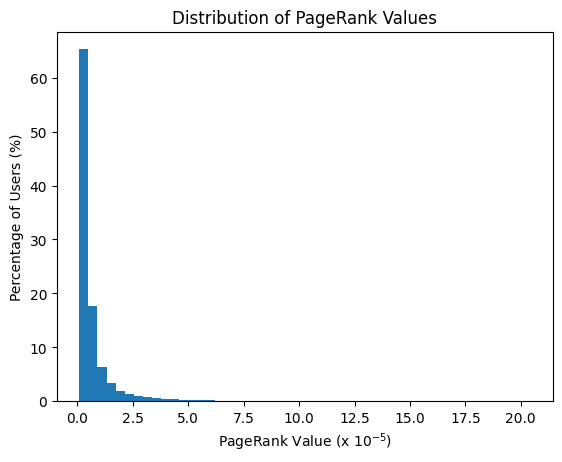

In [15]:
import matplotlib.pyplot as plt
import numpy as np

# Collect the PageRank values and rescale them
pagerank_values = [value * 10**5 for value in result1.vertices.select('pagerank').rdd.flatMap(lambda x: x).collect()]

# Calculate the weights for each bin to normalize the histogram
weights = np.ones_like(pagerank_values) / len(pagerank_values)

# Plot a histogram with y-axis as percentage
plt.hist(pagerank_values, bins=50, weights=weights*100)

plt.xlabel('PageRank Value (x $10^{-5}$)')
plt.ylabel('Percentage of Users (%)')
plt.title('Distribution of PageRank Values')
plt.show()


In [ ]:
page_rank(graph, sourceId="1", maxIter=1).vertices.show()

+---+----------+--------+
| id|out_degree|pagerank|
+---+----------+--------+
|  1|         2|    0.15|
|  2|         1|   0.425|
|  3|         1|   0.425|
+---+----------+--------+


In [ ]:
result2 = page_rank(graph, tol=0.3)

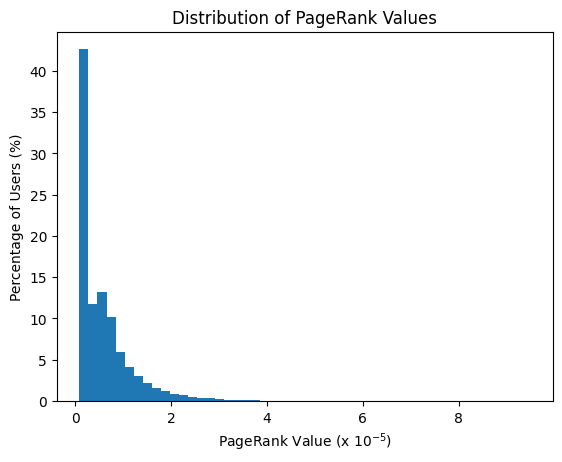

In [17]:
import matplotlib.pyplot as plt
import numpy as np

# Collect the PageRank values and rescale them
pagerank_values = [value * 10**5 for value in result2.vertices.select('pagerank').rdd.flatMap(lambda x: x).collect()]

# Calculate the weights for each bin to normalize the histogram
weights = np.ones_like(pagerank_values) / len(pagerank_values)

# Plot a histogram with y-axis as percentage
plt.hist(pagerank_values, bins=50, weights=weights*100)

plt.xlabel('PageRank Value (x $10^{-5}$)')
plt.ylabel('Percentage of Users (%)')
plt.title('Distribution of PageRank Values')
plt.show()